# Creating Helper Functions

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## To make sure any plots render in the notebook
%matplotlib inline

db = 'chinook.db'

## takes a SQL query as an argument
## and returns a pandas dataframe of the query
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

## Take a SQL command and executes it using the sqlite module
def run_command(command):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.cursor().execute(command)

## call run_query() func to return a list of all tables and views in the DB
def show_tables():
    q = '''
        select
            name,
            type
        from sqlite_master
        where type in ("table", "view");
    '''
    return run_query(q)

show_tables()
    


,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase
Selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store at that moment, which are:
- Regal (Hip-Hop)
- Red Tone (Punk)
- Meteor and the Girls (Pop)
- Slim Jim Bites (Blues)

In [3]:
album_to_purchase = '''
WITH usa_tracks_sold AS
    (
        SELECT il.* FROM invoice_line AS il
        INNER JOIN invoice AS inv ON inv.invoice_id = il.invoice_id
        INNER JOIN customer AS c ON c.customer_id = inv.customer_id
        WHERE c.country = "USA"
    )

SELECT 
    g.name AS genre,
    COUNT(uts.invoice_line_id) AS tracks_sold,
    CAST( COUNT(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) FROM usa_tracks_sold) AS percentage_sold

FROM usa_tracks_sold AS uts
INNER JOIN track AS t ON t.track_id = uts.track_id
INNER JOIN genre AS g ON g.genre_id = t.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10;
'''

run_query(album_to_purchase)


,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


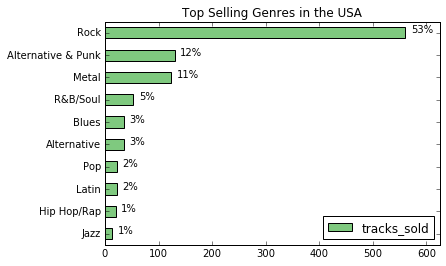

In [4]:
genre_sales_usa = run_query(album_to_purchase)
genre_sales_usa.set_index("genre", drop=True, inplace=True)
genre_sales_usa.sort_values('tracks_sold',ascending=True, inplace=True)

## Plot horizontal bar
genre_sales_usa.plot.barh(
    y="tracks_sold",
    title="Top Selling Genres in the USA",
    xlim=[0, 625],
    colormap=plt.cm.Accent,
    )

## Remove "Genre" to show only list of Genre
plt.ylabel("")

## Annotate percentage sold next to horizontal bar 
for idx, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, idx))
    
plt.show()


Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:
- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combining these three genres only generate up only 17% of the total sales, so we could be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.


# Analyzing Employee Sales Performance

In [5]:
## the total dollar amount of sales assigned to each sales support agent within the company
employee_performance="""
WITH customer_support_rep_sales AS 
    (
    SELECT
        c.customer_id,
        c.support_rep_id,
        SUM(i.total) AS total_purchase
    FROM
        customer AS c
    INNER JOIN invoice AS i USING (customer_id)
    GROUP BY 1,2
    )
SELECT
    e.first_name || " " || e.last_name AS employee,
    e.hire_date,
    SUM(total_purchase) AS total_sales
FROM customer_support_rep_sales as csrs
INNER JOIN employee AS e on e.employee_id = csrs.support_rep_id
GROUP BY employee;
"""
run_query(employee_performance)


,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


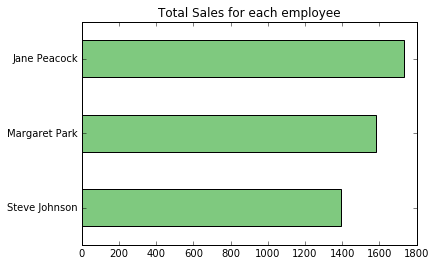

In [6]:
## plot of the results of your query
employee_sales = run_query(employee_performance)
employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values('total_sales', inplace=True)

employee_sales.plot.barh(
    legend=False,
    title="Total Sales for each employee",
    colormap=plt.cm.Accent,
    )

plt.ylabel("")
plt.show()

While there is around 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

# Analyzing Sales by Country

In [7]:
## a country has only one customer, collect them into an "Other" group
sales_by_country ="""
WITH country_or_other AS
    (
    SELECT
        CASE
            WHEN (
                SELECT COUNT(*)
                FROM customer
                WHERE country = c.country
            ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
    FROM invoice_line AS il
    INNER JOIN invoice AS i USING (invoice_id)
    INNER JOIN customer AS c USING (customer_id)
    
    )
SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT 
        country,
        COUNT(distinct customer_id) AS customers,
        SUM(unit_price) AS total_sales,
        SUM(unit_price) / COUNT(DISTINCT invoice_id) AS average_order,
        SUM(unit_price) / COUNT(DISTINCT customer_id) AS customer_lifetime_value,
        CASE
            WHEN country="Other" THEN 1
            ELSE 0
        END AS sort 
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
"""

run_query(sales_by_country )

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


# Visualizing Sales by Country
Find out which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

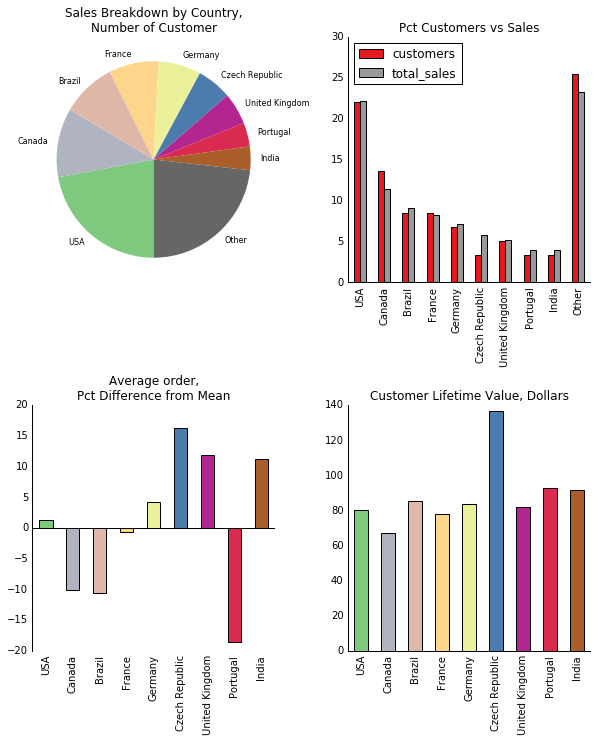

In [53]:

country_metrics = run_query(sales_by_country )
country_metrics.set_index("country", drop=True, inplace=True)
## create a list of colors representing for each country
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

## create subplots figurue
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 11))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.3)

## top left drawing
sales_breakdown = country_metrics["total_sales"].copy().rename("")
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title="Sales Breakdown by Country,\nNumber of Customer",
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth': 0}
)

## top right drawing
cvd_cols = ["customers", "total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ""
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
    
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1, 
    title="Pct Customers vs Sales")
ax2.tick_params(top="off", right="off", left="off", bottom="off")   
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


## bottom left drawing
avg_order = country_metrics["average_order"].copy()
avg_order.index.name=""
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax = ax3,
    color = colors,
    title = "Average order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color="k")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)


## bottom right drawing
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.drop("Other", inplace=True)
ltv.index.name=""
ltv.plot.bar(
    ax = ax4,
    color = colors,
    title = "Customer Lifetime Value, Dollars")
ax4.tick_params(top="off", right="off", left="off", bottom="off")  
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunities in the following countries:
- Czech Republic
- United Kingdom
- India
It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

# Albums vs Individual Tracks
Find out what percentage of purchases are individual tracks vs whole albums by identifying whether each invoice has all the tracks from an album.

In [61]:
albums_vs_tracks="""
with invoice_first_track as
    (
        select
            il.invoice_id invoice_id,
            min(il.track_id) first_track_id
        from invoice_line il
        group by 1
    )
select
    album_purchase,
    count(invoice_id) as number_of_invoices,
    cast(count(invoice_id) as float)/ (select count(*) from invoice) as percent
from
    (
    select
        ifs.*,
        case
            when
                (
                select t.track_id from track as t
                where t.album_id = (
                                    select t2.album_id from track as t2
                                    where t2.track_id = ifs.first_track_id
                                    )

                except

                select il2.track_id from invoice_line as il2
                where il2.invoice_id = ifs.invoice_id              
                ) is null
            and
                (
                select il2.track_id from invoice_line as il2
                where il2.invoice_id = ifs.invoice_id
                
                except
                
                select t.track_id from track as t
                where t.album_id = (
                                    select t2.album_id from track as t2
                                    where t2.track_id = ifs.first_track_id
                                    )
                
                ) is null
            then "yes"
            else "no"
        end as "album_purchase"
    from invoice_first_track as ifs
    )
group by album_purchase;

"""

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.